# <center> Майнор "Интеллектуальный анализ данных" <center>

# <center> Курс "Современные методы машинного обучения" <center>

# <center> Лабораторная работа №1. Supervised learning <center>

## Table of contents  
  
* [Часть 1. Работа с данными](#part1)
* [Часть 2. Методы машинного обучения](#part2)
* [Часть 3. Соревнование по машинному обучению](#part3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

sns.set_style("dark")

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

from scipy.stats import loguniform

from catboost import CatBoostClassifier, Pool 

In [2]:
def tmp_mtrcs(answ, pr):
    return np.array([metrics.f1_score(answ,pr),
                    metrics.recall_score(answ,pr, zero_division=0),
                    metrics.precision_score(answ,pr, zero_division=0),
                    metrics.accuracy_score(answ,pr),
                    metrics.balanced_accuracy_score(answ,pr)])

def prnt_mtrcs(arr_num):
    print('F1: %.5f' %  arr_num[0])
    print('recall: %.5f' %  arr_num[1])
    print('precision: %.5f' % arr_num[2])
    print('accuracy: %.5f' % arr_num[3])
    print('balanced accuracy: %.5f' % arr_num[4])

In [3]:
def csv(model):
    model.fit(X, Y)

    preds = model.predict(df_test)
    df_subm = pd.DataFrame()
    df_subm['ID'] = pd.read_csv('test.csv', sep=';')['ID']
    df_subm['Churn'] = preds
    df_subm.to_csv('subm_'+str(model)[:str(model).find('(')]+'.csv', index=False)

## Часть 1. Работа с данными <a id="part1"></a>

*Вес в общей оценке - 0.3*

В данной части лабораторной вам предстоит работать с данными по оттоку клиентов одной телекомуникационной компании.

Данные находятся в файле `train.csv`

При решении заданий старайтесь писать лаконичный и эффективный код; использовать методы `Pandas`.

**Описание данных:**

In [4]:
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', None)

In [5]:
pd.read_csv('telecom_churn_description.csv')

,Признак,Описание,Тип
0,ID,Уникальный идентификатор объекта,Числовой (integer)
1,Sex,Пол,Символьный
2,Age,Возраст,Числовой (integer)
3,State,Буквенный код штата,Символьный
4,Account length,Как долго клиент обслуживается компанией,Числовой (integer)
5,Phone number,Номер телефона клиента,Символьный
6,Plans,Подключенные планы,Символьный (None; International/Voice mail or both)
7,Number vmail messages,Количество голосовых сообщений,Числовой (integer)
8,Total day minutes,Общая длительность разговоров днем,Числовой (float)
9,Total day calls,Общее количество звонков днем,Числовой (float)


### Задание 1  
  
Считайте данные из файла. Оцените размерность данных, есть ли в данных пропущенные значения. Посмотрите на автоматически определенные типы признаков.

In [6]:
data = pd.read_csv('train.csv', sep=';')
data.head(5)

,ID,Sex,Age,State,Account length,Phone number,Plans,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Total charge,Customer service calls,Churn
0,10001,Female,35.0,MN,150,415 695 24 37,Voice mail,28,174.4,75.0,29.65,169.9,80.0,14.44,201.6,130.0,9.07,11.0,4.0,2.97,56.13,1,0
1,10010,Female,43.0,AR,87,408 673 99 45,None,0,185.8,119.0,31.59,192.3,83.0,16.35,200.0,96.0,9.00,6.6,4.0,1.78,58.72,1,0
2,10029,Female,39.0,ND,180,415 693 30 62,None,0,224.9,105.0,38.23,250.0,101.0,21.25,216.1,73.0,9.72,6.7,5.0,1.81,71.01,3,1
3,10030,Female,36.0,AL,200,408 248 27 61,None,0,128.2,87.0,21.79,133.2,105.0,11.32,177.6,123.0,7.99,11.2,2.0,3.02,44.12,1,0
4,10122,Male,37.0,DE,122,510 297 57 75,None,0,157.1,134.0,26.71,184.9,122.0,15.72,197.2,59.0,8.87,8.5,5.0,2.30,53.6,4,1


Имеем данные о 2499 клиентах.

In [7]:
data.shape

(2499, 23)

Видно, что есть пропуски и некоторые признаки отнесены к неправильному типу.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      2499 non-null   int64  
 1   Sex                     2499 non-null   object 
 2   Age                     1757 non-null   float64
 3   State                   2499 non-null   object 
 4   Account length          2499 non-null   int64  
 5   Phone number            2499 non-null   object 
 6   Plans                   2428 non-null   object 
 7   Number vmail messages   2499 non-null   int64  
 8   Total day minutes       2499 non-null   object 
 9   Total day calls         2499 non-null   object 
 10  Total day charge        2499 non-null   float64
 11  Total eve minutes       2499 non-null   float64
 12  Total eve calls         2499 non-null   float64
 13  Total eve charge        2499 non-null   float64
 14  Total night minutes     2499 non-null   

### Задание 2  
  
Приведите числовые признаки, которые были распознаны некорректно, к числовому типу данных.  
Найдите и опишите ошибки в данных, которые мешают приведению типов. Сколько признаков содержат ошибки, сколько наблюдений по каждому такому признаку? Исправьте эти ошибки и снова выполните приведение типов.  
**NB:** Исправлять ошибки необходимо программно (используя python), изменять исходный файл "руками" не разрешается. 

Признаки неверно определённые как не числовые.

In [9]:
non_num = data.dtypes[data.dtypes == 'object'].index.tolist()[4:]
non_num

['Total day minutes',
 'Total day calls',
 'Total night minutes',
 'Total intl minutes',
 'Total charge',
 'Customer service calls']

Было выяснено(с помощью двойного forа и функции isfloat, которая представленна ниже), что содержаться ошибки видов:

1) o вместо 0

2) l вместо 1

3) , вместо . 

4) присутствует слово hundred в стобце Total charge

In [10]:
def isfloat(n):
    try:
        float(n)
        return True
    except:
        return False

for i in non_num:
    for j in data[i]:
        new_val = j
        
        if not isfloat(j):
            for x, y in ('o', '0'), ('l', '1'), (',', '.'), (' hundred', ''):
                new_val = new_val.replace(x, y)
            
            if 'hundred' in j:
                new_val = str(float(new_val)*100)
            
            data.loc[data[i] == j, i] = new_val

In [11]:
data[non_num] = data[non_num].apply(pd.to_numeric)

Попробуем найти другие опечатки в данных.

In [12]:
rem_non_num = data.dtypes[data.dtypes == 'object'].index.tolist()
rem_non_num

['Sex', 'State', 'Phone number', 'Plans']

In [13]:
for col in rem_non_num:
    print(col, ':', data[col].unique())

Sex : ['Female' 'Male']
State : ['MN' 'AR' 'ND' 'AL' 'DE' 'NE' 'GA' 'NC' 'DC' 'IA' 'MS' 'NH' 'NY' 'AZ'
 'UT' 'IN' 'WI' 'OK' 'WV' 'OR' 'ID' 'FL' 'NV' 'WY' 'MI' 'KS' 'KY' 'VA'
 'MT' 'PA' 'NM' 'IL' 'NJ' 'CO' 'LA' 'CA' 'MD' 'SD' 'OH' 'ME' 'SC' 'TN'
 'WA' 'AK' 'MA' 'RI' 'HI' 'VT' 'MO' 'TX' 'CT']
Phone number : ['415 695 24 37' '408 673 99 45' '415 693 30 62' ... '510 191 97 69'
 '415 846 60 88' '408 739 90 49']
Plans : ['Voice mail' 'None' 'International, Voice mail' 'International' nan]


Видно, что в признак Sex, State, Plans опечаток нет.
Признак Phone number пока трогать не будем и проверим его позже, если вдруг будем использовать.

### Задание 3  
  
Оцените набор данных на предмет пропущенных значений. Какие признаки содержат пропуски? Сколько наблюдений с пропусками по каждому такому признаку?  
По каждому признаку предложите и обоснуйте, что делать с пропущенными значениями. 

Есть пропуски в признаках Age и Plans.

In [14]:
for col in data.columns:
    num_nan = data.shape[0] - data[col].value_counts().sum()
    if num_nan != 0:
        print(col, num_nan, 'NaN')

Age 742 NaN
Plans 71 NaN


В Plans мало пропусков, кроме того, подавляющее большинство значений у этого параметра None.

In [15]:
data['Plans'].value_counts()

None                         1568
Voice mail                    618
International                 167
International, Voice mail      75
Name: Plans, dtype: int64

Видно, что люди у которых пропущенно это поле Plans, пользуются голосовой почтой также, как люди, у которых в этом поле None. А по поводу роуминга сказать что либо сложно.

In [16]:
data_test = data.copy()
data_test['Plans'] = data_test['Plans'].fillna('???')

In [17]:
data_test.pivot_table(['Number vmail messages', 'Total intl calls'], 
['Plans'], aggfunc='mean')

,Number vmail messages,Total intl calls
Plans,,
???,0.000000,4.661972
International,0.000000,4.700599
"International, Voice mail",29.586667,5.026667
None,0.000000,4.458865
Voice mail,29.145631,4.484628


Заполняем пропуски.

In [18]:
data['Plans'] = data['Plans'].fillna('None')

1) Коррелция Age с Churn интуитивно не очевидно, кроме того её не видно на графике.
2) Видно, что мы имеем дело с одной возрастной группой
3) У нас отсутствует треть значений

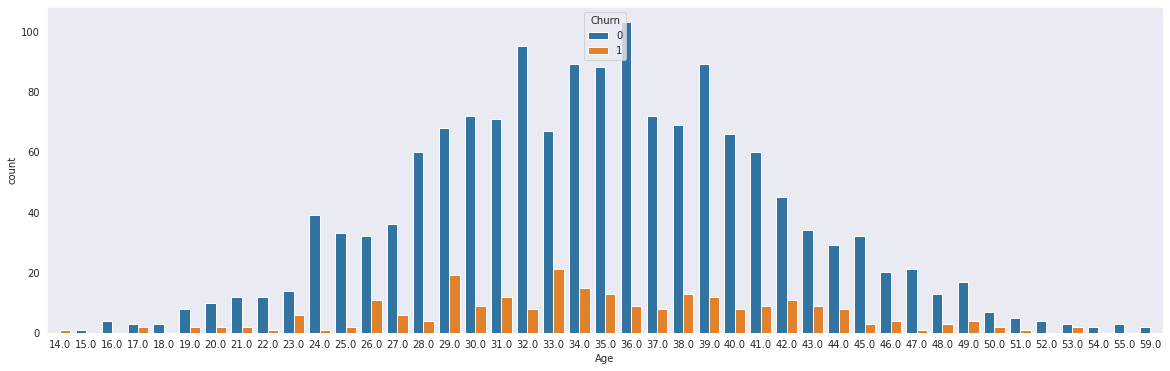

In [19]:
plt.figure(figsize=(20,6))
sns.countplot(x='Age', hue='Churn', data=data)
plt.show()

Видим, что ID коррелирует с Churn сильнее, чем Age!

In [20]:
data[['Age', 'ID', 'Churn']].corr()

,Age,ID,Churn
Age,1.000000,-0.002838,0.002066
ID,-0.002838,1.000000,-0.002658
Churn,0.002066,-0.002658,1.000000


Поэтому удалим признак Age.

In [21]:
data.drop(['Age'], axis=1, inplace=True)

### Задание 4  
  
В признаке `Phone number` первые три цифры номера отвечают за код зоны покрытия сети.  
Создайте новый признак `Area code`, содержайщий код покрытия сети.  
Вычислите, сколько таких зон представлено в данных. Сколько наблюдений по каждой зоне?  
Вычислите, сколько штатов входит в каждую зону. Есть ли штаты, которые находятся сразу в нескольких зонах покрытия? Если есть, приведите примеры.

Создаём новый признак Area code.

In [22]:
data.insert(loc=6, column='Area code', value=[int(i[0:3]) for i in data['Phone number']]) 

Смотрим на количество наблюдений в каждой зоне. И сразу убеждаемся, что опечаток, по крайней мере в первых 3 цифрах, в телефонных номерах нет. 

In [23]:
data['Area code'].value_counts()

415    1247
408     632
510     620
Name: Area code, dtype: int64

Каждая зона покрывает все штаты.

In [24]:
for code in data['Area code'].value_counts().index:
    print(str(code) + ':', data[data['Area code'] == code]['State'].unique().shape[0])

415: 51
408: 51
510: 51


Таким образом, любой штат находиться в нескольких зонах покрытия.

### Задание 5  
  
Вычислите тарифные планы (стоимость минуты разговора): day, eve, night, intl.  
Проверьте, различаются ли они для различных зон покрытия сети. 

In [25]:
tariff_plans = ('day', 'eve', 'night', 'intl')

Заметим, что есть люди, которые вообще не использовали тот или иной тарифный план.

In [26]:
for i in tariff_plans:
    print(i + ':', data[data['Total ' + i + ' minutes'] == 0].shape[0])

day: 1
eve: 1
night: 0
intl: 10


Создадим признак для каждого тарифа. 0 заменим на среднее, тк их очень мало.

In [27]:
for i in tariff_plans:
    data[i + ' rate'] = data['Total ' + i + ' charge']/data['Total ' + i + ' minutes']
    data.loc[data['Total ' + i + ' minutes'] == 0.0, i + ' rate'] = data[i + ' rate'].mean()

 Видим, что различных значений получаетя очень много, кроме того, они все лежат в маленьком промежутке.
 Скорее всего, оплата производилась посекундно, а не поминутно.

In [28]:
for i in tariff_plans:
    max, min = data[i + ' rate'].max(), data[i + ' rate'].min()
    print(i + ':\n', ' от %.4f до %.4f' % (min, max))
    print(' ', data[i + ' rate'].unique().shape[0], 'различных значений')

day:
  от 0.1692 до 0.1705
  1118 различных значений
eve:
  от 0.0849 до 0.0851
  1170 различных значений
night:
  от 0.0448 до 0.0451
  1159 различных значений
intl:
  от 0.2690 до 0.2727
  115 различных значений


Поэтому за цену минуты разумно взять среднее.

In [29]:
data[[i + ' rate' for i in tariff_plans]].mean()

day rate      0.170003
eve rate      0.085001
night rate    0.045000
intl rate     0.270060
dtype: float64

Странно, но стоимость минуты intl не зависит от Plans.

In [30]:
for i in data['Plans'].unique():
    print(i, 'mean: %.5f' % data[data['Plans'] == i]['intl rate'].mean())

Voice mail mean: 0.27007
None mean: 0.27006
International, Voice mail mean: 0.27005
International mean: 0.27003


Ну и очевидно, что тарифы не зависят от зоны покрытия.

Удаляем только что созданные признаки.

In [31]:
for i in tariff_plans:
    data.drop([i + ' rate'], axis=1, inplace=True)

### Задание 6  
  
По каждому штату и каждому плану в признаке `Plans` (International и Voice mail) вычислите количество клиентов, подключивших этот план и их долю **внутри штата**. Пример вывода:
  
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>State</th>
      <th>Plan</th>
      <th>Count</th>
      <th>Frac</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>state_1</td>
      <td>International</td>
      <td>40</td>
      <td>0.4</td>
    </tr>
    <tr>
      <th>1</th>
      <td>state_1</td>
      <td>Voice mail</td>
      <td>30</td>
      <td>0.3</td>
    </tr>
    <tr>
      <th>2</th>
      <td>state_2</td>
      <td>International</td>
      <td>25</td>
      <td>0.5</td>
    </tr>
    <tr>
      <th>3</th>
      <td>state_2</td>
      <td>Voice mail</td>
      <td>35</td>
      <td>0.7</td>
    </tr>
  </tbody>
</table>

Создадим DataFrame.

In [32]:
df_pl = pd.DataFrame()
df_pl['State'] = [i for i in data['State'].unique() for j in range(2)]
df_pl['Plan'] = [j  for i in data['State'].unique() for j in ['International', 'Voice mail']]
df_pl['Count'], df_pl['Frac'] = np.nan, np.nan

In [33]:
for i in data['State'].unique():
    for j in ['International', 'Voice mail']:
        val_tmp = data[(data['State'] == i) & (data['Plans'] == j)].shape[0]
        val_tmp += data[(data['State'] == i) & (data['Plans'] == 'International, Voice mail')].shape[0]
        
        df_pl.loc[(df_pl['State'] == i) & (df_pl['Plan'] == j), 'Count'] = int(val_tmp)
        
        num_people_st = data[data['State'] == i].shape[0]
        
        df_pl.loc[(df_pl['State'] == i) & (df_pl['Plan'] == j), 'Frac'] = val_tmp/num_people_st

In [34]:
df_pl

,State,Plan,Count,Frac
0,MN,International,3.0,0.044776
1,MN,Voice mail,21.0,0.313433
2,AR,International,7.0,0.152174
3,AR,Voice mail,11.0,0.239130
4,ND,International,7.0,0.148936
...,...,...,...,...
97,MO,Voice mail,14.0,0.280000
98,TX,International,4.0,0.076923
99,TX,Voice mail,12.0,0.230769
100,CT,International,5.0,0.098039


### Задание 7  
  
Для нечисловых признаков выполните преобразование к числовому виду. Обоснуйте выбранное преобразование для каждого признака. 

Phone number уникальный для всех, поэтому не имеет смысла его использовать. Так как вся полезная информация из номера содержиться в Area code, то можем считать, что мы заменили  Phone number на Area code.

In [35]:
data.drop(['Phone number'], axis=1, inplace=True)

In [36]:
labelencoder = LabelEncoder()
data['State'] = labelencoder.fit_transform(data['State'])

Видим, что Churn вообще не зависит от Sex. Поэтому можно просто удалить этот признак.

In [37]:
pd.crosstab(data['Churn'], data['Sex'], margins=True)

Sex,Female,Male,All
Churn,,,
0,1080,1057,2137
1,183,179,362
All,1263,1236,2499


In [38]:
data.drop(['Sex'], axis=1, inplace=True)

Вместо Plans можно ввести 2 параметра. Один отвечает за Voice mail, другой за International.

In [39]:
data['Roaming'], data['Voice mail'] = 0, 0

data.loc[(data['Plans'] == 'International') | (data['Plans'] == 'International, Voice mail'),'Roaming'] = 1

data.loc[(data['Plans'] == 'Voice mail') | (data['Plans'] == 'International, Voice mail'),'Voice mail'] = 1

In [40]:
data.drop(['Plans'], axis=1, inplace=True)

### Задание 8  
  
Сколько линейно-зависимых признаков присутствует в данных?  
Определите и удалите признаки, которые линейно зависят от остальных.

У нас точно есть линейно зависимые признаки.

In [41]:
data.shape[1] - np.linalg.matrix_rank(data)

1

Не сложно догадаться, что это группа признаков ...charge.

In [42]:
df = data[['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', 'Total charge']]

In [43]:
df.shape[1] - np.linalg.matrix_rank(df)

1

Поэтому удалим признак Total charge.

In [44]:
data.drop(['Total charge'], axis=1, inplace=True)

Как мы узнали ранее тарифные планы для всех пользователей одинаковые, поэтому можем удалить все признаки содержащие Charge.

In [45]:
data.drop(['Total ' + i +' charge' for i in tariff_plans], axis=1, inplace=True)

Мы знаем, что те у кого не подклчена голосовая почта не могу её использовать и наоборот, все, у кого она подключена её используют.

In [46]:
data[data['Voice mail'] == 1]['Number vmail messages'].min()

4

Поэтому можем удалить созданный нами признак Voice mail

In [47]:
data.drop(['Voice mail'], axis=1, inplace=True)

### Задание 9  
  
Проведите анализ зависимости признаков.  
Для числовых признаков вычислите корреляции друг с другом и с целевой переменной `Churn`. Постройте heatmap.  
Для категориальных признаков оцените их связь с целевой переменной, постройте графики.  
  
Сделайте выводы по результатм анализа. Можно ли избавиться от некоторых признаков? Если да, то от каких и почему?

Сразу удалим ID.

In [48]:
data.drop(['ID'], axis=1, inplace=True)

Видно, что Churn не зависит от Area code

In [49]:
pd.crosstab(data['Churn'], data['Area code'], margins=True)

Area code,408,415,510,All
Churn,,,,
0,533,1077,527,2137
1,99,170,93,362
All,632,1247,620,2499


In [50]:
data.drop(['Area code'], axis=1, inplace=True)

Корреляция всех оставшихся признаков.

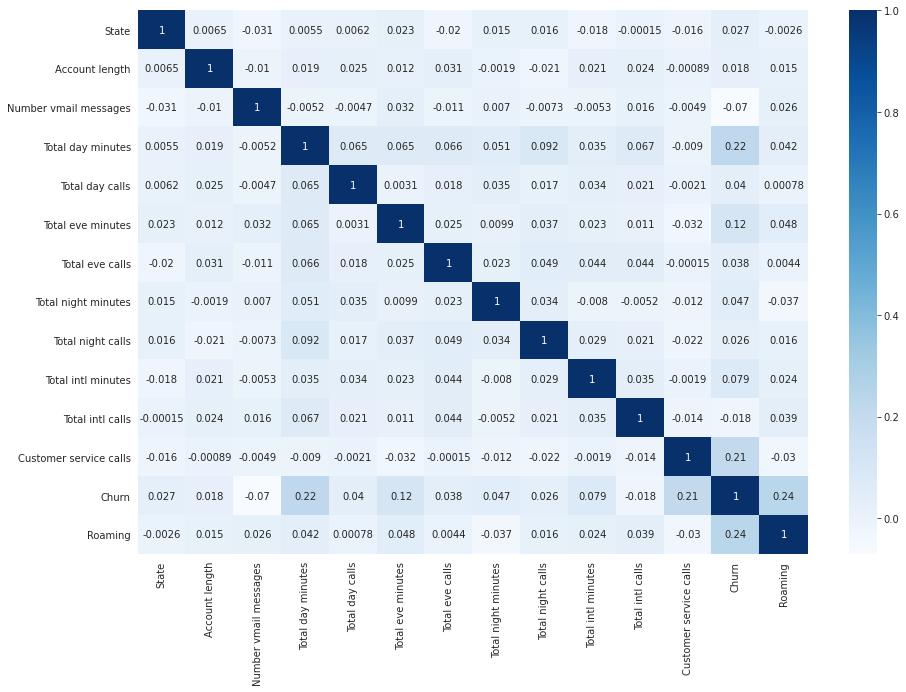

In [51]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, cmap='Blues')
plt.show()

### Задание 10  
  
Рассмотрим основанную на правилах модель для предсказания оттока клиентов: 
* Если у пользователя подключен роуминг (International plan) & клиент звонил в тех. поддержку более 3-х раз => клиент уйдет (Churn = True)
* Иначе => клиент останется (Churn = False)  
  
  
Оцените качество данной модели на 5-fold валидации из 5 повторений. Для оценки качества рассмотрите различные метрики: F1-score, precision, recall, accuracy, balanced accuracy. Дайте комментарий к оценке.

In [52]:
X = data.drop('Churn', axis=1)
Y = data['Churn']

In [53]:
X['pred'] = 0
X.loc[(X['Roaming'] == 1) & (X['Customer service calls'] > 3), 'pred'] = 1

Найдём средние значения метрик по всем 5 повторения 5-fold валидации.

In [54]:
mtrcs_sum = [0]*5

for i in range(5):
    kf = KFold(n_splits=5, shuffle=True, random_state = 228*i)
    kf.get_n_splits(X)

    for _, test_index in kf.split(X):
        pr = X.iloc[test_index]['pred']
        answ = Y[test_index]

        mtrcs_sum += tmp_mtrcs(answ, pr)
        
mtrcs_mean = mtrcs_sum/25   

prnt_mtrcs(mtrcs_mean)

F1: 0.06659
recall: 0.03550
precision: 0.57400
accuracy: 0.85755
balanced accuracy: 0.51611


F1 всегда очень низкая. Recall так же очень низкий, модель пропускает большинство ушедших клиентов. Precision не такой низкий, но в любом случае плохой, модель часто путает клиентов которые уйдут и тех, которые остануться. Accuracy высокий из-за того, что клиентов, которые ушли значительно меньше. Balanced accuracy уже не такое высокое.
Модель плохая!

Значения на всех данных не сильно отличаются от средних на k-fold. Что не удивительно!

Roc auc находится около значения 0.5, а это практически минимальное значение.

In [55]:
prnt_mtrcs(tmp_mtrcs(Y, X['pred']))

F1: 0.06806
recall: 0.03591
precision: 0.65000
accuracy: 0.85754
balanced accuracy: 0.51632


Если вообще не учитывать количество звонков в поддержку, то некоторые метрики ненмого возрастают.

In [56]:
X['pred'] = 0
X.loc[X['Roaming'] == 1, 'pred'] = 1
prnt_mtrcs(tmp_mtrcs(Y, X['pred']))

F1: 0.32119
recall: 0.26796
precision: 0.40083
accuracy: 0.83593
balanced accuracy: 0.60005


In [57]:
X.drop(['pred'], axis=1, inplace=True)

# Преобразование тестовых данных

In [58]:
df_test = pd.read_csv('test.csv', sep=';')

In [59]:
df_test.drop(['Total day charge', 'Total eve charge',
              'Total night charge', 'Total intl charge',
              'Total charge', 'ID', 'Sex', 'Age', 'Phone number'], axis=1, inplace=True)

In [60]:
df_test['Plans'] = df_test['Plans'].fillna('None')

In [61]:
df_test['Roaming'] = 0

df_test.loc[(df_test['Plans'] == 'International') | (df_test['Plans'] == 'International, Voice mail'),'Roaming'] = 1

In [62]:
df_test.drop(['Plans'], axis=1, inplace=True)

In [63]:
labelencoder = LabelEncoder()
df_test['State'] = labelencoder.fit_transform(df_test['State'])

In [64]:
non_num = df_test.dtypes[df_test.dtypes == 'object'].index.tolist()

In [65]:
for i in non_num:
    for j in df_test[i]:
        new_val = j
        
        if not isfloat(j):
            for x, y in ('o', '0'), ('l', '1'), (',', '.'), (' hundred', ''):
                new_val = new_val.replace(x, y)
            if 'hundred' in j:
                new_val = str(float(new_val)*100)
            
            df_test.loc[df_test[i] == j, i] = new_val

In [66]:
df_test[non_num] = df_test[non_num].apply(pd.to_numeric)

## Часть 2. Методы машинного обучения <a id="part2"></a>

*Вес в общей оценке - 0.5*

Продолжаем работать с данными по оттоку клиентов.  
Сформулируем задачу машинного обучения: необходимо построить модель, определяющую, останется клиент или уйдет. 
  
Для решения заданий, представленных ниже, необходимо использовать данные, полученные после выполнения всех преобразований в первой части. 

### Задание 1  
  
* Постройте дерево решений глубины 5 (остальные параметры по умолчанию), оцените качество на 5-fold валидации.  
* Для одного из деревьев (т.е. обученного на одной из итераций кросс-валидации) выведите само дерево - постройте график или выведите в текстовом виде. По структуре дерева сформулируйте правила, по которым принимается решение.  
* Сравните между собой деревья решений, полученных на различных итерациях 5-fold валидации. Сделайте вывод, насколько сильно они похожи или различаются между собой. 

Значения метрик на каждой итерации.

In [67]:
kf = KFold(n_splits=5, shuffle=True, random_state = 322)
kf.get_n_splits(X)

mtrcs_sum = [0]*5

for train_index, test_index in kf.split(X):
        dt = DecisionTreeClassifier(max_depth=5)
        dt.fit(X.iloc[train_index], Y.iloc[train_index])
        
        pr = dt.predict(X.iloc[test_index])
        answ = Y[test_index]
        
        prnt_mtrcs(tmp_mtrcs(answ, pr))
        print()
        
        mtrcs_sum += tmp_mtrcs(answ, pr)

mtrcs_mean = mtrcs_sum/5   

F1: 0.64286
recall: 0.53731
precision: 0.80000
accuracy: 0.92000
balanced accuracy: 0.75826

F1: 0.72152
recall: 0.67059
precision: 0.78082
accuracy: 0.91200
balanced accuracy: 0.81602

F1: 0.74227
recall: 0.64286
precision: 0.87805
accuracy: 0.95000
balanced accuracy: 0.81580

F1: 0.80556
recall: 0.72500
precision: 0.90625
accuracy: 0.94400
balanced accuracy: 0.85536

F1: 0.75000
recall: 0.68919
precision: 0.82258
accuracy: 0.93186
balanced accuracy: 0.83165



Средние значения всех метрик.

In [70]:
prnt_mtrcs(mtrcs_mean)

F1: 0.72916
recall: 0.64828
precision: 0.83631
accuracy: 0.93077
balanced accuracy: 0.81306


Самое лучшее дерево четвёртое, поэтому посмотрим на него.

In [71]:
ind_tr = list(kf.split(X))[3][0]

x_train_kf = X.iloc[ind_tr]
y_train_kf = Y.iloc[ind_tr]

In [72]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(x_train_kf, y_train_kf)

dot_data = export_graphviz(dt, 
                           out_file=None, 
                           feature_names=x_train_kf.columns, 
                           class_names=['0', '1'],
                           filled=True, 
                           rounded=True, 
                           special_characters=True)

graph = graphviz.Source(dot_data) 

В основном дерево смотрит на количество звонков/минут. Людей которые много звонят, оно относит к классу "ушедших", а тех, которые мало к классу "оставшихся". 

Изначально дерево смотри много ли люди говорят по телефону днём, затем смотрит на подключённые услуги и количество звонков в поддержку. А дальше уже смотрит по различным "типам звонков"(описано выше).

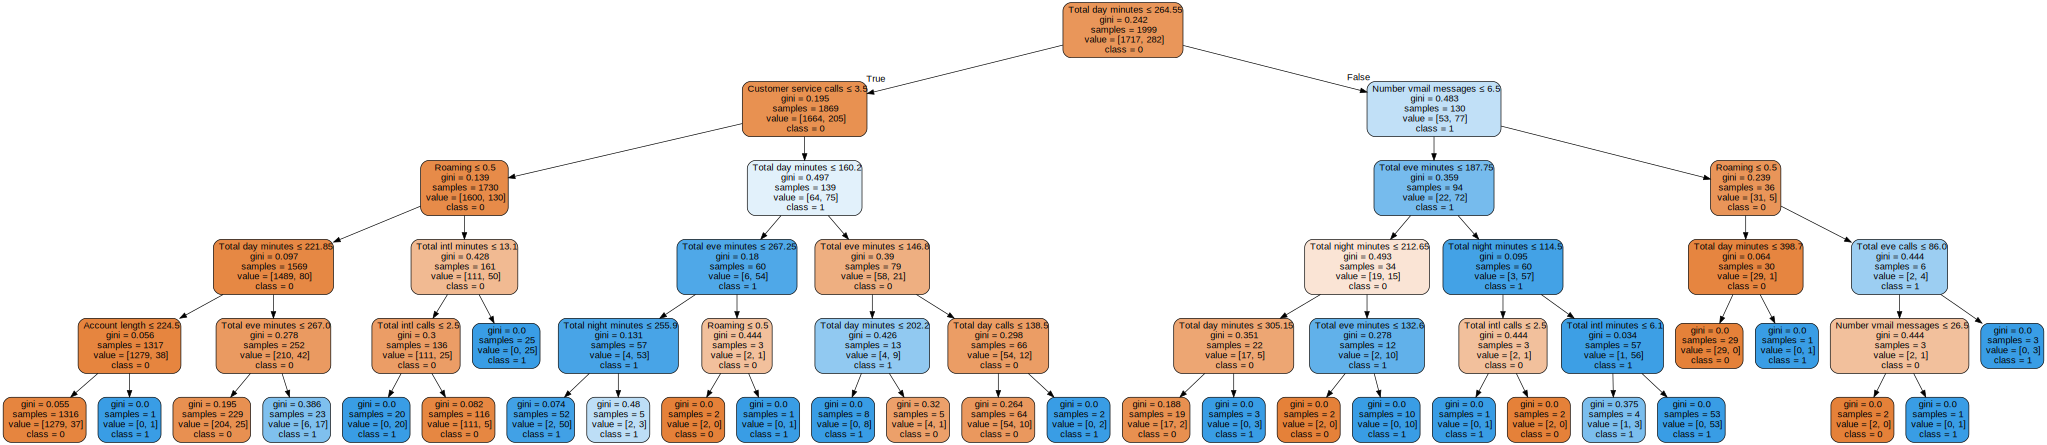

In [73]:
display(graph)

### Задание 2  
  
На кросс-валидации (5-fold из 5 повторений) оцените, как меняется качество модели Random Forest с ростом числа деревьев (при дефолтных значениях остальных параметров). Провизуализируйте результаты. Сколько деревьев достаточно в данном случае и почему?  
**NB:** В сравнение включите конфигурацию, аналогичную простому дереву решений. 

Где-то начиная с 60 деревьев можно точно сказать, что f1 и roc auc практически перестают расти, поэтому 65 деревьев точно будет достаточно.

In [169]:
def func1(f, n, s):
    scores_f1, scores_roc = [], []
    for i in range(f, n, s):
        rf = RandomForestClassifier(n_estimators=i, random_state=1337)
        skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1337)


        res = cross_validate(rf, X, Y, cv=skf, scoring=['f1_macro', 'roc_auc'], n_jobs=-1)
        scores_f1.append(np.mean(res['test_f1_macro']))
        scores_roc.append(np.mean(res['test_roc_auc']))

    plt.figure(figsize = (15, 6))
    plt.plot([i for i in range(f, n, s)], scores_f1, 
             marker='o', color='pink', label='f1')
    plt.plot([i for i in range(f, n, s)], scores_roc, 
             marker='o', color='mediumvioletred', label='roc auc')
    plt.legend()
    plt.show()


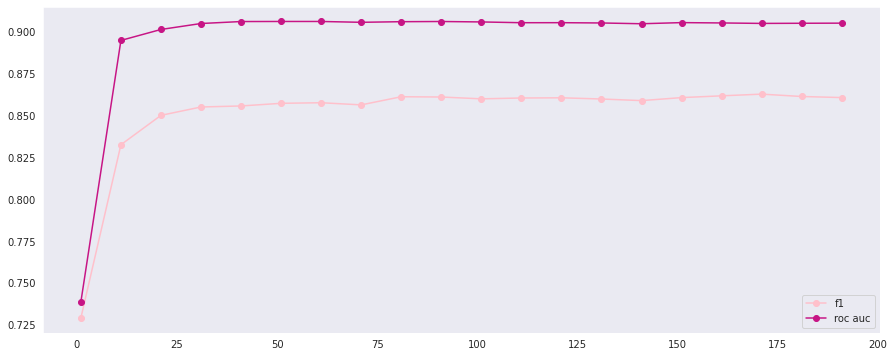

CPU times: user 3.03 s, sys: 111 ms, total: 3.14 s
Wall time: 1min 46s


In [170]:
%%time
func1(1, 200, 10)

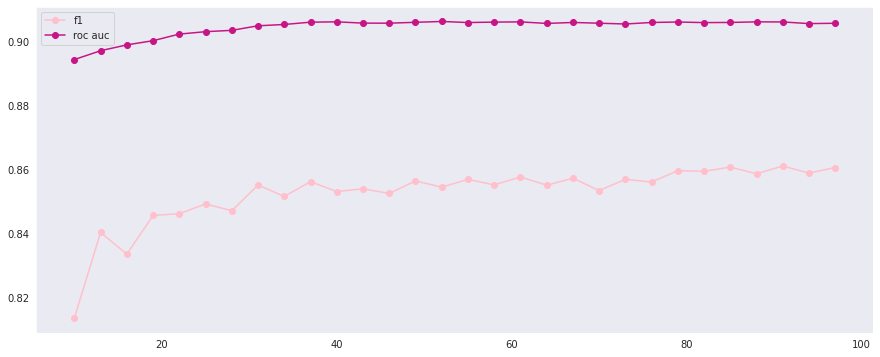

CPU times: user 4.15 s, sys: 142 ms, total: 4.29 s
Wall time: 1min 26s


In [171]:
%%time
func1(10, 100, 3)

### Задание 3  
  
* Настройте гиперпараметры модели Random Forest на 5-fold валдиации из 5 повторений. В качестве метрики используйте F1-score. Замерьте время, затраченное на вычисления.
* Разделите данные на обучающую и тестовую выборки в пропорциях 70:30 (сохраните seed). Обучите Random Forest  с настроенными параметрами на обучающей выборке. На тестовой выборке оцените качество (F1-score) всего ансамбля и <u>каждого дерева отдельно</u>. Постройте график распределения качества деревьев в ансамбле и сравните результаты с качеством всего леса. Дайте комментарий.  
* Выведите важность признаков в Random Forest, сделайте выводы. 

In [74]:
rf = RandomForestClassifier(n_estimators=65, random_state=1337)
params = {'max_depth': np.arange(5,40)}

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1337)

rf_grid = GridSearchCV(rf, params, cv=rskf, scoring='f1_macro', n_jobs=-1)


In [75]:
%%time
rf_grid.fit(X, Y)
rf_grid.best_params_

CPU times: user 5 s, sys: 147 ms, total: 5.15 s
Wall time: 1min 44s


{'max_depth': 24}

Разобьём данные.

In [69]:
(trainData, 
 testData, 
 train_label, 
 test_label) = train_test_split(X,
                                Y,
                                test_size=0.3, 
                                random_state=54335)

Проверим распределение значений целевой переменной.

In [175]:
train_label.value_counts(normalize=True)

0    0.856489
1    0.143511
Name: Churn, dtype: float64

In [176]:
test_label.value_counts(normalize=True)

0    0.852
1    0.148
Name: Churn, dtype: float64

Обучим модель с наилучшими параметрами.

In [76]:
rf = RandomForestClassifier(n_estimators=65, **rf_grid.best_params_, random_state=1337)
rf.fit(trainData, train_label)

preds = rf.predict(testData)

rf_f1 = metrics.f1_score(test_label, preds)

In [178]:
rf_f1

0.8167539267015707

Посмотрим на деревья по отдельности.

In [179]:
dt_f1 = []
for dt in rf.estimators_:
    dt.fit(trainData, train_label)

    preds = dt.predict(testData)

    dt_f1.append(metrics.f1_score(test_label, preds))

**Распределение качества деревьев.**

Распределение нормальное. Качетсво всего леса(красная линия на графике) заметно выше, чем у любого из деревьев.
Разница с большинством деревьев составляет 0.2 по f1, а с самыми лучшими 0.1, что весьма значительно.

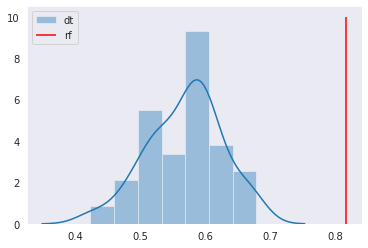

In [180]:
sns.distplot(dt_f1, hist=True, label='dt')
plt.vlines(x=rf_f1, ymin=0, ymax=10, label='rf', colors='red')
plt.legend(loc='upper left')
plt.show()

**Важность признаков.**

Примерно такую же картину мы могли видеть в корреляционной табличке и у дерева в задании 1. 
Правда в случае леса, признак roaming "ниже", чем в выше описанных случаях.

In [181]:
for i in np.argsort(rf.feature_importances_)[::-1]:
    print(X.columns[i])

Total day minutes
Customer service calls
Total eve minutes
Total intl minutes
Roaming
Total night minutes
Number vmail messages
Total intl calls
Account length
Total night calls
Total day calls
Total eve calls
State


### Задание 4  
  
* Используйте логистическую регрессию для решения задачи, подберите оптимальные значения гипермараметров. Оцените качество (roc auc) на 5-fold валидации из 5 повторений. 
* Аналогично (на такой же валидации (тех же подвыборках) с такой же метрикой) оцените качество Random Forest  с подобранными в предыдущем задании параметрами. Сравните с качеством логистическом регрессии.
* Разделите данные на обучающую и тестовую выборки в пропорциях 70:30 (используйте тот же seed, что и в Задании 3). На обучающей выборке обучите логистическую регрессию и Random Forest  с настроенными параметрами. Для обеих моделей оцените качество на тестовой выборке - постройте ROC-кривую, вычислите roc auc.

In [68]:
sc = StandardScaler().fit(X)
X_sc = sc.transform(X)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1337)

Видим, что при сильной регуляризации начинает падать f1.
Стандартное значение C=1 нам в принципе подходит, тк начиная с 0.1 значение f1 и roc auc практически не меняются.

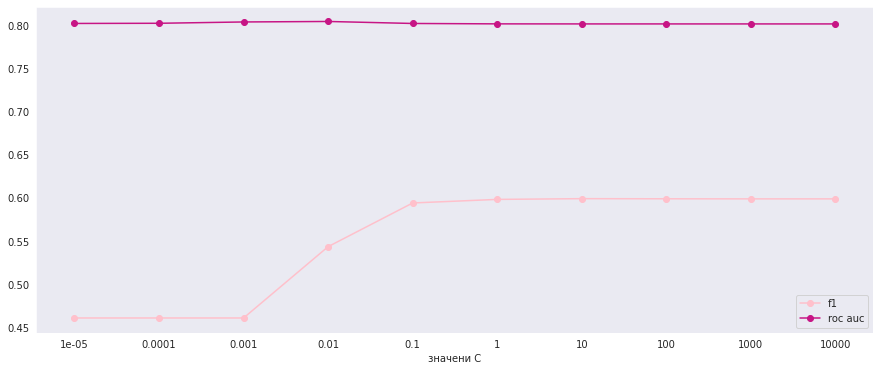

In [183]:
C_nums = [1*(10**i) for i in range(-5, 5)]
scores_f1, scores_roc = [], []
for i in C_nums:
    lr = LogisticRegression(C=i, n_jobs=-1, max_iter=100000, random_state=322)

    res = cross_validate(lr, X_sc, Y, cv=rskf, scoring=['f1_macro', 'roc_auc'])
    scores_f1.append(np.mean(res['test_f1_macro']))
    scores_roc.append(np.mean(res['test_roc_auc']))

plt.figure(figsize = (15, 6))
plt.plot(scores_f1, 
             marker='o', color='pink', label='f1')
plt.plot(scores_roc, 
             marker='o', color='mediumvioletred', label='roc auc')
plt.xticks(range(10), C_nums)
plt.legend()
plt.xlabel('значени C')
plt.show()

Видим, что логистическая регрессия уступает лесу по метрики roc auc.

Логистическая регрессия.

In [184]:
np.mean(cross_val_score(lr, X_sc, Y, cv=rskf, n_jobs=-1, scoring='roc_auc'))

0.8013701717901317

Рандомный лес.

In [185]:
np.mean(cross_val_score(rf, X_sc, Y, cv=rskf, n_jobs=-1, scoring='roc_auc'))

0.9055604403862353

Построим roc-кривую. Видим, что roc-кривая леса практически всегда больше кривой регрессии.

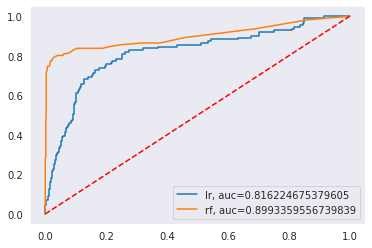

In [82]:
lr = LogisticRegression(n_jobs=-1, max_iter=100000, random_state=322)

lr.fit(sc.transform(trainData), train_label)
pred_lr = lr.predict_proba(sc.transform(testData))

rf.fit(trainData, train_label)
pred_rf = rf.predict_proba(testData)

fpr_lr, tpr_lr, _ = metrics.roc_curve(test_label,  pred_lr[::,1])
auc_lr = metrics.roc_auc_score(test_label,  pred_lr[::,1])
plt.plot(fpr_lr,tpr_lr,label='lr, auc='+str(auc_lr))

fpr_rf, tpr_rf, _ = metrics.roc_curve(test_label,  pred_rf[::,1])
auc_rf = metrics.roc_auc_score(test_label,  pred_rf[::,1])
plt.plot(fpr_rf,tpr_rf,label='rf, auc='+str(auc_rf))

plt.plot([0,1], c='red', linestyle='--')

plt.legend(loc=4)
plt.show()

### Задание 5  
  
Для алгоритма AdaBoost с параметрами по умолчанию оцените на 5-fold валидации, как растет качество модели на обучающей и на тестовой выборках при добавлении каждого дерева. Провизуализируйте результаты. 

Начинаем с 50 деревьев и добавляем по одному. На каждом шаге сначала берём среднее значение F1 на 5-fold на трейне и потом сравниваем его со значением F1 на тесте.

Нельзя сказать, как меняется качество модели при добавлении одного дерева. Но видно, что при большом увеличении числа деревьев обобщающая способность модели увеличивается.

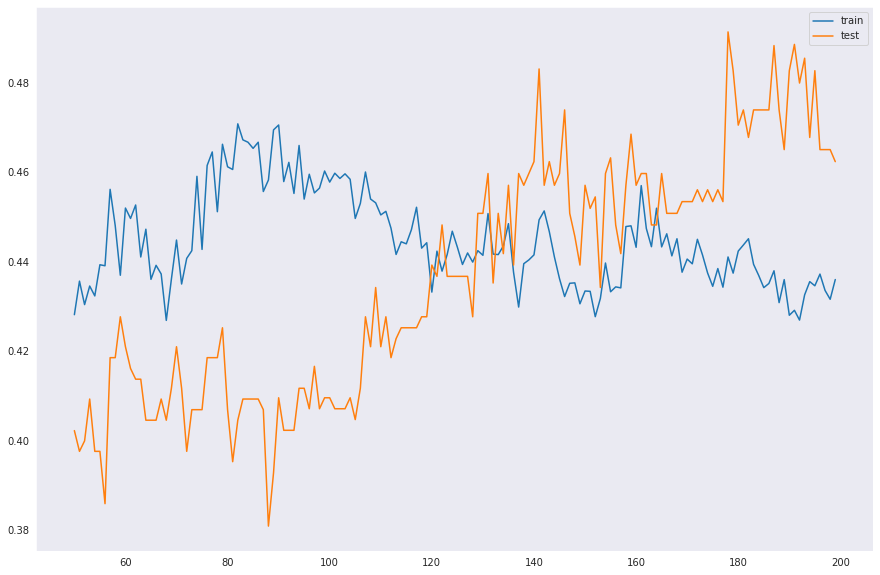

CPU times: user 6min 17s, sys: 328 ms, total: 6min 17s
Wall time: 6min 17s


In [187]:
%%time
kf = KFold(n_splits=5, shuffle=True, random_state = 1337)
kf.get_n_splits(trainData)

test_f1, train_f1 = [], []

n_est = range(50, 200, 1)

for i in n_est:
    mtrcs_sum_train = 0

    for train_index, test_index in kf.split(trainData):
        ada = AdaBoostClassifier(n_estimators=i, random_state=1337) 
        ada.fit(trainData.iloc[train_index], train_label.iloc[train_index])
        
        pr = ada.predict(trainData.iloc[test_index])
        answ = train_label.iloc[test_index]

        mtrcs_sum_train += metrics.f1_score(answ, pr)

    train_f1.append(mtrcs_sum_train/5)
        
    ada = AdaBoostClassifier(n_estimators=i, random_state=1337) 
    ada.fit(trainData, train_label)
    
    pr = ada.predict(testData)
    answ = test_label

    test_f1.append(metrics.f1_score(answ, pr))

plt.figure(figsize=(15, 10))
plt.plot(n_est, train_f1, label='train')
plt.plot(n_est, test_f1, label='test')
plt.legend()

plt.show()

### Задание 6  
  
* Настройте гиперпараметры AdaBoost на 5-fold валидации, используя в качестве базовых классификаторов дерево решений и SVM. В качестве метрики используйте F1-score. Замерьте время, затраченное на вычисления.    
* Выведите наилучшую конфигурацию параметров для каждого базового классификатора. Сравните качество. 

**Decision Tree**

In [188]:
ada = AdaBoostClassifier(random_state=1337)
params = {'n_estimators': np.arange(1, 10, 1),
         'base_estimator': [DecisionTreeClassifier(max_depth=i, random_state=1337) for i in range(1, 10)]}

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1337)

ada_grid_dt = GridSearchCV(ada, params, cv=rskf, scoring='f1_macro', n_jobs=-1)

In [189]:
%%time
ada_grid_dt.fit(X, Y)
ada_grid_dt.best_params_

CPU times: user 845 ms, sys: 68 ms, total: 913 ms
Wall time: 10.8 s


{'base_estimator': DecisionTreeClassifier(max_depth=6, random_state=1337),
 'n_estimators': 1}

In [190]:
ada_dt = AdaBoostClassifier(**ada_grid_dt.best_params_, random_state=1337)
ada_dt.fit(trainData, train_label)
preds = ada_dt.predict(testData)
ada_dt_f1 = metrics.f1_score(test_label, preds)

**SVM**

Тюнинг SVM без буста.

In [191]:
sv = SVC(kernel='poly', random_state=1337)
params = {'degree': np.arange(2, 10),
         'C': loguniform(1e1, 1e4)}

sv_rs = RandomizedSearchCV(sv, params, cv=rskf, scoring='f1_macro', n_iter=100, n_jobs=-1, random_state=322)

In [192]:
%%time
sv_rs.fit(X_sc, Y)
sv_rs.best_params_

CPU times: user 2.36 s, sys: 43.6 ms, total: 2.41 s
Wall time: 7min 53s


{'C': 18.906003016264613, 'degree': 3}

In [193]:
sv = SVC(kernel='poly', **sv_rs.best_params_,random_state=1337)

In [194]:
np.mean(cross_val_score(sv, X_sc, Y, cv=rskf, n_jobs=-1, scoring='f1_macro'))

0.7617317680079843

Добавляем буст, подбираем количество моделей.

Получилось не очень удачно.

In [195]:
ada_sv = AdaBoostClassifier(base_estimator=sv, algorithm='SAMME', random_state=1337)
params = {'n_estimators': np.arange(1, 100, 1)}

ada_sv_rs = RandomizedSearchCV(ada_sv, params, cv=rskf, scoring='f1_macro', n_iter=30, n_jobs=-1, random_state=323)


In [196]:
%%time
ada_sv_rs.fit(X_sc, Y)
ada_sv_rs.best_params_

CPU times: user 24.7 s, sys: 702 ms, total: 25.4 s
Wall time: 11min 37s


{'n_estimators': 74}

In [197]:
ada_sv = AdaBoostClassifier(base_estimator=sv, **ada_sv_rs.best_params_, algorithm='SAMME', random_state=1337)

In [198]:
np.mean(cross_val_score(ada_sv, X_sc, Y, cv=rskf, n_jobs=-1, scoring='f1_macro'))

0.5727617680029201

Тюним всё вместе.

In [199]:
sv = SVC(kernel='poly', random_state=1337)
ada_sv = AdaBoostClassifier(base_estimator=sv, algorithm='SAMME', random_state=1337)
params = {'base_estimator__degree': np.arange(2, 10),
         'base_estimator__C': loguniform(1e-2, 1e2),
         'n_estimators': np.arange(1, 30, 5)}

ada_sv_rs = RandomizedSearchCV(ada_sv, params, cv=rskf, scoring='f1_macro', n_iter=10, n_jobs=-1, random_state=323)


In [200]:
%%time
ada_sv_rs.fit(X_sc, Y)
ada_sv_rs.best_params_

CPU times: user 6.89 s, sys: 99.9 ms, total: 6.99 s
Wall time: 1min 9s


{'base_estimator__C': 78.26253331777104,
 'base_estimator__degree': 2,
 'n_estimators': 21}

In [201]:
sv = SVC(kernel='poly', degree=2, C=78, random_state=1337)
ada_sv = AdaBoostClassifier(base_estimator=sv, n_estimators=21, algorithm='SAMME', random_state=1337)
np.mean(cross_val_score(ada_sv, X_sc, Y, cv=rskf, n_jobs=-1, scoring='f1_macro'))

0.7206892469447072

На рандоме получили неплохой результат. Сужаем выборку гиперпараметров.

In [202]:
sv = SVC(kernel='poly', random_state=1337)
ada_sv = AdaBoostClassifier(base_estimator=sv, algorithm='SAMME', random_state=1337)
params = {'base_estimator__degree': np.arange(2, 5),
         'base_estimator__C': np.arange(50, 100, 5),
         'n_estimators': np.arange(5, 40, 5)}

ada_sv_rs = GridSearchCV(ada_sv, params, cv=rskf, scoring='f1_macro', n_jobs=-1)

In [203]:
%%time
ada_sv_rs.fit(X_sc, Y)
ada_sv_rs.best_params_

CPU times: user 14.1 s, sys: 226 ms, total: 14.3 s
Wall time: 30min 26s


{'base_estimator__C': 80, 'base_estimator__degree': 3, 'n_estimators': 30}

In [204]:
sv = SVC(kernel='poly', degree=3, C=80, random_state=1337)
ada_sv = AdaBoostClassifier(base_estimator=sv, n_estimators=30, algorithm='SAMME', random_state=1337)
np.mean(cross_val_score(ada_sv, X_sc, Y, cv=rskf, n_jobs=-1, scoring='f1_macro'))

0.7450966646024407

Пробуем подобрать параметры наиболее точно.

In [205]:
sv = SVC(kernel='poly', random_state=1337)
ada_sv = AdaBoostClassifier(base_estimator=sv, algorithm='SAMME', random_state=1337)
params = {'base_estimator__C': np.arange(75, 85, 1),
         'n_estimators': np.arange(25, 35, 1)}

ada_sv_rs = GridSearchCV(ada_sv, params, cv=rskf, scoring='f1_macro', n_jobs=-1)

In [206]:
%%time
ada_sv_rs.fit(X_sc, Y)
ada_sv_rs.best_params_

CPU times: user 12.2 s, sys: 164 ms, total: 12.4 s
Wall time: 22min 43s


{'base_estimator__C': 83, 'n_estimators': 31}

In [207]:
sv = SVC(kernel='poly', degree=3, C=83, random_state=1337)
ada_sv = AdaBoostClassifier(base_estimator=sv, n_estimators=31, algorithm='SAMME', random_state=1337)
np.mean(cross_val_score(ada_sv, X_sc, Y, cv=rskf, n_jobs=-1, scoring='f1_macro'))

0.7473567045238296

In [208]:
ada_sv.fit(sc.transform(trainData), train_label)
preds = ada_dt.predict(sc.transform(testData))
ada_sv_f1 = metrics.f1_score(test_label, preds)

**Итог**

Лучшая конфигурация для дерева.

In [209]:
ada_dt.base_estimator_

DecisionTreeClassifier(max_depth=6, random_state=1337)

Значение F1 для дерева.

In [210]:
print(ada_dt_f1)

0.7487179487179488


Лучшая конфигурация для SVM.

In [211]:
ada_sv.base_estimator_

SVC(C=83, kernel='poly', random_state=1337)

Значение F1 для SVM.

In [212]:
print(ada_sv_f1)

0.34375


### Задание 7  
  
* Используйте для решения задачи один из фреймворков градиентного бустинга: XGBoost, LightGDB или CatBoost.  
* Оцените на 5-fold валидации, как растет качество модели на обучающей и на тестовой выборках при добавлении каждого дерева. Провизуализируйте результаты.  
* Настройте гиперпараметры модели на 5-fold валидации, в качестве метрики используйте F1-score. Замерьте время, затраченное на вычисления.  
* Разделите данные на обучающую и тестовую выборки в пропорциях 70:30 (используйте тот же seed, что и в Задании 3). Обучите модель с настроенными параметрами на обучающей выборке. На тестовой выборке оцените качество. Сравните с предыдущими моделями, дайте комментарий.  
* Оцените важность признаков в обученной модели с оптимальными параметрами. 

In [85]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1337)

При добавлении первого дерева качество резко падает, при добавлении нескольких следующих резко возрастает. Где-то начиная со 2 дерева качество перестаёт меняться на тесте, а начиная с 20 перестаёт меняться на трейне.

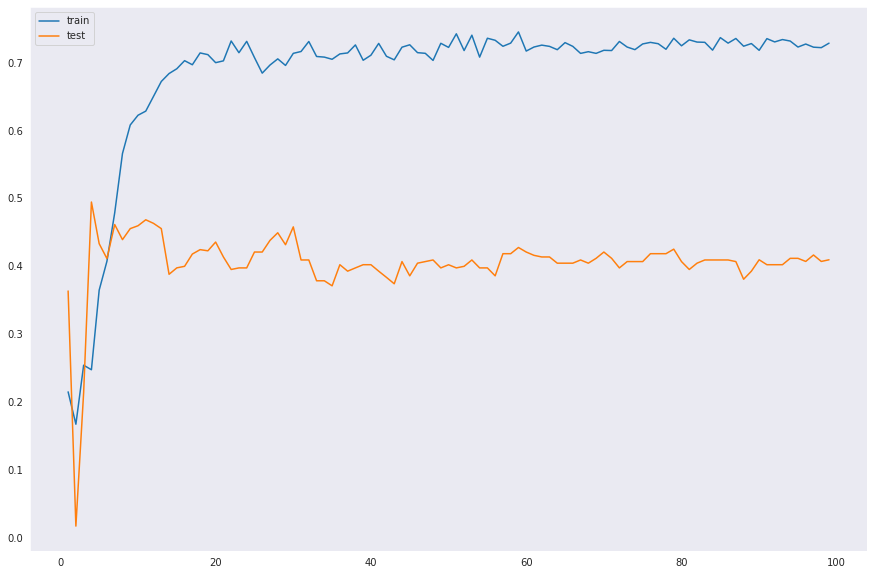

CPU times: user 4min 17s, sys: 14.7 s, total: 4min 32s
Wall time: 5min 45s


In [214]:
%%time
kf = KFold(n_splits=5, shuffle=True, random_state = 1337)
kf.get_n_splits(trainData)

test_f1, train_f1 = [], []

n_est = range(1, 100, 1)

for i in n_est:
    mtrcs_sum_train = 0

    for train_index, test_index in kf.split(trainData):
        cb = CatBoostClassifier(iterations=i, random_seed=322, verbose=False)
        cb.fit(trainData.iloc[train_index], train_label.iloc[train_index])
        
        pr = cb.predict(trainData.iloc[test_index])
        answ = train_label.iloc[test_index]

        mtrcs_sum_train += metrics.f1_score(answ, pr)

    train_f1.append(mtrcs_sum_train/5)
        
    cb = AdaBoostClassifier(n_estimators=i, random_state=1337) 
    cb.fit(trainData, train_label)
    
    pr = cb.predict(testData)
    answ = test_label

    test_f1.append(metrics.f1_score(answ, pr))

plt.figure(figsize=(15, 10))
plt.plot(n_est, train_f1, label='train')
plt.plot(n_est, test_f1, label='test')
plt.legend()

plt.show()

Настройка гиперпараметров.

In [86]:
cb = CatBoostClassifier(verbose=False, random_seed=67897)

params = {'depth': [6, 10],
        'l2_leaf_reg': loguniform(1e0, 1e3),
        'random_strength': loguniform(1e0, 1e3),
        'bagging_temperature': loguniform(1e0, 1e3)}


cb_rs = RandomizedSearchCV(cb, params, cv=rskf, scoring='f1', n_iter=10, n_jobs=-1, random_state=323)


In [87]:
%%time
cb_rs.fit(X, Y)
cb_rs.best_params_

/home/nikitos/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 6.72 s, sys: 361 ms, total: 7.08 s
Wall time: 4min 32s


{'bagging_temperature': 7.414075255729104,
 'depth': 6,
 'l2_leaf_reg': 24.412759063908577,
 'random_strength': 4.541403635214745}

In [88]:
%%time
cb = CatBoostClassifier(**cb_rs.best_params_, random_seed=67897)
np.mean(cross_val_score(cb, X, Y, cv=rskf, n_jobs=-1, scoring='f1'))

CPU times: user 56.2 ms, sys: 4.38 ms, total: 60.6 ms
Wall time: 11.9 s


0.8011397320876199

ЯНДЕКС ЛУЧШЕ ВСЕХ!!!!!!!!!!

In [89]:
cb.fit(trainData, train_label, verbose=False)
pred = cb.predict(testData)
print(metrics.f1_score(test_label, pred))

0.8205128205128205


Важность признаков. Похожа на то, что было у леса, важность признака ещё больше коррелирует с его корреляцией.

In [90]:
for i in np.argsort(cb.feature_importances_)[::-1]:
    print(X.columns[i])

Total day minutes
Customer service calls
Total eve minutes
Roaming
Number vmail messages
Total intl minutes
Total night minutes
Total intl calls
Total night calls
State
Total eve calls
Total day calls
Account length


## Часть 3. Соревнование по машинному обучению <a id="part3"></a>

*Вес в общей оценке - 0.3*

В данном задании вам предлагается принять участие в [Inclass соревновании](https://www.kaggle.com/t/b25354482b484011b3b782da84d61186) на Kaggle.  
Задача соревнования заключается в том, чтобы как можно лучше решить задачу предсказания оттока клиентов.  
  
Метрикой качества (точности) решения в данном соревновании является **ROC AUC**. 

Для участия в соревновании, т.е. для того, чтобы сабмитить результаты, вам необходимо создать аккаунт на [kaggle](https://www.kaggle.com/).

После того, как вы выполните сабмит, в leaderboard вы сможете посмотреть качество вашей модели на тестовой выборке и место в общем зачете.  
Вы можете делать много (до 10 в день) сабмитов - в leaderbord всегда отображается самый лучший (остальные можно посмотреть в `My Submissions`).

**NB:** Обратите внимание, что текущий рейтинг (до конца соревнования) строится только на части тестовых данных. После окончания соревнования рейтинг будет пересчитан на всех данных и позиции могут измениться.
Вы можете сами выбрать три модели (сабмита), которые будут провалидированы на всех данных. По умолчанию будут выбраны три модели, давшие лучший результат в текущем рейтинге.

### Задание  
  
Необходимо построить и засабмитить модель, которая:   
* Задача минимум – покажет на тестовой выборке качество выше baseline: TBD
* Задача максимум - решит задачу как можно точнее.  
  
При решении можно и нужно выполнять различные преобразования признаков и применять различные модели машинного обучения.  

В качестве результата необходимо: 
* Сказать ваш логин на kaggle, чтобы мы могли распознать вас в leaderboard. 
* Для лучшей модели:
    * Предоставить скрипт\ноутбук, выполнив который можно получить файл для сабмита (чтобы можно было воспроизвести ваш результат). Также необходимо предоставить саму сохраненную модель.  
    * Предоставить скрипт\ноутбук для преобразования данных и обучения лучшей модели. 
    * (Опционально) Предоставить ноутбук с результатами для других моделей\сабмитов, которые вы пробовали.  
  
По результатам будет составлен наш локальный leaderboard, и по нему будут определены баллы за задание. 

### Баллы за место в итоговом рейтинге  
  
* 1-5 место: 10 баллов
* 6-10 место: 9 баллов  
* 11-15 место: 8 баллов
* 16-25 место: 7 баллов  
* 26-35 место: 6 баллов
* 36-50 место: 5 баллов
* 51-65 место: 4 балла
* 66-80 место: 3 балла
* 81-... место: 2 балла  
  
**NB:** Чтобы получить баллы за соревнование, нужно превзойти baseline. В противном случае будет 0 баллов. 

In [221]:
csv(RandomForestClassifier(n_estimators=200, max_depth=11, random_state=1337))

In [222]:
csv(AdaBoostClassifier(n_estimators=1,
                                base_estimator=DecisionTreeClassifier(max_depth=6, random_state=1337),
                                random_state=1337))

In [223]:
csv(LogisticRegression(n_jobs=-1, max_iter=1000000, random_state=322))

In [224]:
csv(AdaBoostClassifier(base_estimator= SVC(kernel='poly', degree=3, C=83, random_state=1337),
                            n_estimators=31, algorithm='SAMME', random_state=1337))

In [83]:
csv(CatBoostClassifier(iterations=100000, verbose=False))